# Reactor Physics

**Inputs**: 2-group homogenized cross sections (HXS) ($cm^{-1}$)

- `FissionFast`: $\nu\Sigma_f^1$
- `CaptureFast`: $\Sigma_a^1$
- `FissionThermal`: $\nu\Sigma_f^2$
- `CaptureThermal`: $\Sigma_a^2$
- `Scatter12`: $\Sigma_s^{1 \rightarrow 2}$
- `Scatter11`: $\Sigma_s^{1 \rightarrow 1}$
- `Scatter21`: $\Sigma_s^{2 \rightarrow 1}$
- `Scatter22`: $\Sigma_s^{2 \rightarrow 2}$

**Outputs**

- `k`: Neutron multiplication factor

This data set consists of 1000 observations with eight inputs and one output. The data is taken from [[RSOGradyK19]](https://pymaise.readthedocs.io/en/stable/index.html#id3), a sensitivity analysis using the Shapley effect. The geometry of the problem is a pressurized water reactor (PWR) lattice based on the BEAVRS benchmark. The lattice is a $17 \times 17$ PWR with $264~UO_2$ fuel rods, 24 guide tubes, and one instrumentation tube. The lattice utilizes quarter symmetry in TRITON and is depleted to $50~GWD/MTU$. To construct the data set, a two-step process was used: (1) the uncertainty in the fundamental microscopic XS data was propagated, and (2) these XSs were collapsed into a 2-group form using the following equation

\begin{equation}
\Sigma_x^g = \frac{\int_{\Delta E_g}dE \int_V \Sigma_{x,m}(E) \phi(r,E,t) dV}{\int_{\Delta E_g}dE\int_V\phi(r,E,t)dV}.
\end{equation}

The sampler module in SCALE was used for uncertainty propagation, and the 56-group XS and covariance libraries were used in TRITON to create 56-group HXSs using the above equation. These HXSs are then collapsed into a 2-group library. 1000 random samples were taken from the Sampler [[RSOGradyK19]](https://pymaise.readthedocs.io/en/stable/index.html#id3).

To start pyMAISE, the general packages are imported below.

In [1]:
from pyMAISE.datasets import load_xs
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

We can load the reactor physics preprocessor by `pyMAISE.datasets.load_xs()` and by defining that it is a regression problem below.

In [2]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_xs()

The data consists of 8 inputs:

In [3]:
inputs

<xarray.DataArray (index: 1000, variable: 8)>
array([[0.0064462 , 0.00924782, 0.130007  , ..., 0.482483  , 0.00150595,
        1.12546   ],
       [0.00635893, 0.00934703, 0.128811  , ..., 0.490558  , 0.00149675,
        1.12616   ],
       [0.0064674 , 0.00925333, 0.129465  , ..., 0.486784  , 0.00149345,
        1.12423   ],
       ...,
       [0.00649919, 0.00934518, 0.129862  , ..., 0.490898  , 0.00151782,
        1.1289    ],
       [0.00647664, 0.00944998, 0.130726  , ..., 0.494716  , 0.0015138 ,
        1.12734   ],
       [0.0062723 , 0.00960541, 0.130317  , ..., 0.502067  , 0.00150592,
        1.1264    ]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'FissionFast' 'CaptureFast' ... 'Scatter22'

and one output with 1000 data points:

In [4]:
outputs

<xarray.DataArray (index: 1000, variable: 1)>
array([[1.256376],
       [1.241534],
       [1.256988],
       [1.261442],
       [1.253744],
       [1.261324],
       [1.246886],
       [1.249954],
       [1.25212 ],
       [1.258008],
       [1.256793],
       [1.247149],
       [1.253193],
       [1.249416],
       [1.24956 ],
       [1.246953],
       [1.248573],
       [1.261022],
       [1.247053],
       [1.249361],
...
       [1.256116],
       [1.239636],
       [1.269848],
       [1.249036],
       [1.24979 ],
       [1.262373],
       [1.256964],
       [1.246652],
       [1.250859],
       [1.251616],
       [1.251508],
       [1.25897 ],
       [1.259301],
       [1.247735],
       [1.244721],
       [1.256407],
       [1.24553 ],
       [1.251895],
       [1.255878],
       [1.240064]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'k'

To get a better idea of the data we can create a corrilation matrix using the `pyMAISE.preprocessing.correlation_matrix()` function.

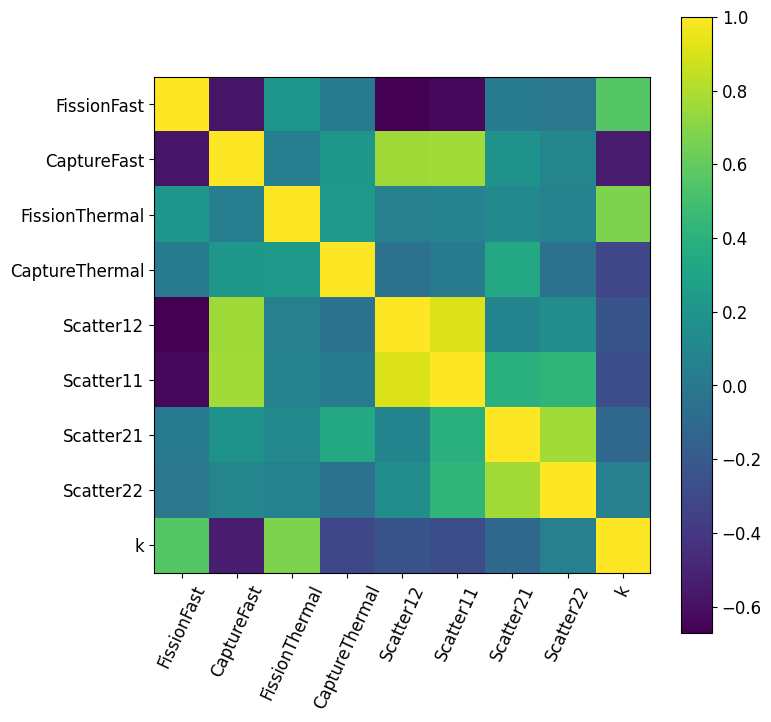

In [5]:
correlation_matrix(data)
plt.show()

There is a positive correlation between `k` with `FissionFast` and `FissionThermal`. There is also a strong negative correlation of `k` with `CaptureFast`.

The last step is to preprocess the data by scaling. We will min-max scale this data.

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 7 regression models in this data set:

- linear: `Linear`,
- lasso: `Lasso`,
- support vector machine: `SVM`,
- decision tree: `DT`,
- random forest: `RF`,
- k-nearest neighbors regression: `KN`,
- dense feedforward neural network: `FNN`.

For hyperparameter tuning, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayers, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [7]:
model_settings = {
    "models": ["Linear", "Lasso", "SVM", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=400),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

The hyperparameter tuning spaces are defined below. We use random search for the classical models as their training is quick, and random search can cover ample parameter space. Bayesian search is utilized for the FNNs as their training is more computationally expensive. Both search methods use 5-fold cross-validation to mitigate bias from the training data. We train 200 classical models from random search and 50 iterations of Bayesian search for neural networks. 

In [8]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "SVM": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200,
    n_jobs=6,
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 24.35803848107656 minutes to process.


We can now see the Bayesian search hyperparameter optimization in the convergence plot.

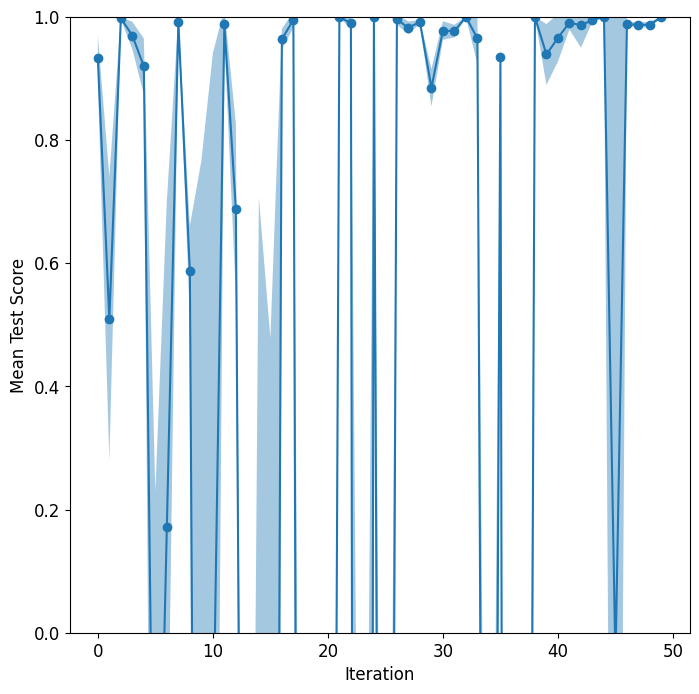

In [9]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

## Model Postprocessing

With the top `pyMAISE.Settings.num_configs_saved`, we can pass these parameter configurations to the `pyMAISE.PostProcessor` for model comparison and analysis. For the FNNs, we define the `"epochs"` parameter as 200 for better performance.

In [10]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

To compare the performance of these models, we will compute five metrics for both the training and testing data: 

- mean absolute percentage error: `MAPE` $=\frac{100}{n} \sum_{i = 1}^n \frac{|y_i - \hat{y}_i|}{\text{max}(\epsilon, |y_i|)}$,
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y}_i)^2}$,
- root mean squared percentage error `RMSPE` $= \sqrt{\frac{1}{n}\sum_{i = 1}^n\Big(\frac{y_i - \hat{y}_i}{\text{max}(\epsilon, |y_i|)}\Big)^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y}_i|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y}_i)^2}{\sum^n_{i = 1}(y_i - \bar{y}_i)^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\bar{y}$ is the model predicted outcome, and $n$ is the number of observations. Metrics for `k` are shown below.

In [11]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
0,Linear,0.999930,0.000043,0.003422,0.000061,0.004873,0.999923,0.000044,0.003505,0.000065,0.005215
27,FNN,0.999916,0.000040,0.003152,0.000067,0.005287,0.999808,0.000041,0.003303,0.000103,0.008126
28,FNN,0.999955,0.000039,0.003154,0.000049,0.003879,0.999787,0.000050,0.004009,0.000109,0.008775
30,FNN,0.999925,0.000051,0.004049,0.000063,0.005007,0.999685,0.000060,0.004775,0.000132,0.010669
26,FNN,0.999773,0.000106,0.008467,0.000110,0.008752,0.999672,0.000112,0.008944,0.000135,0.010731
1,Lasso,0.999657,0.000106,0.008432,0.000135,0.010738,0.999585,0.000121,0.009699,0.000152,0.012095
2,Lasso,0.999636,0.000109,0.008689,0.000139,0.011057,0.999561,0.000125,0.009990,0.000156,0.012441
29,FNN,0.999365,0.000176,0.014100,0.000183,0.014654,0.999333,0.000182,0.014550,0.000192,0.015389
3,Lasso,0.999297,0.000152,0.012164,0.000193,0.015372,0.999174,0.000173,0.013824,0.000214,0.017078
4,Lasso,0.999268,0.000156,0.012421,0.000197,0.015690,0.999141,0.000177,0.014101,0.000218,0.017416


The top-performing models based on test $R^2$ are linear regression, lasso regression, and the FNNs. This indicates a very linear data set. K-nearest neighbors, random forest, and decision tree overfit to the training data.

The hyperparameter configurations of the top-performing models are listed below.

In [12]:
for model in ["Lasso", "SVM", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.00015044717694598402

Model Type: SVM
  degree: 2
  gamma: scale
  kernel: poly

Model Type: DT
  max_depth: 31
  max_features: None
  min_samples_leaf: 5
  min_samples_split: 10

Model Type: RF
  criterion: poisson
  max_features: 6
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 116

Model Type: KN
  leaf_size: 13
  n_neighbors: 7
  p: 3
  weights: distance

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 95
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.0003421585453407753
    batch_size: 8
Model: "FNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_hidden_0 (Dense)      (None, 95)                855       
                                                                 
 Dense_output_0 (Dense)      (None, 1)                 96        
                    

Below is the network plot for the FNN.

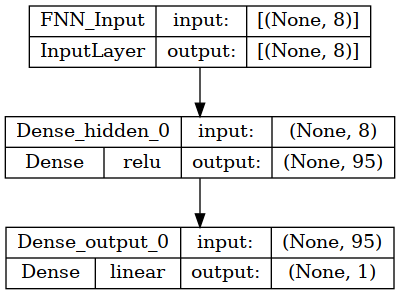

In [13]:
postprocessor.nn_network_plot(
    to_file="./supporting/reactor_physics_network.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

We can better visualize the performance of each model with diagonal validation plots.

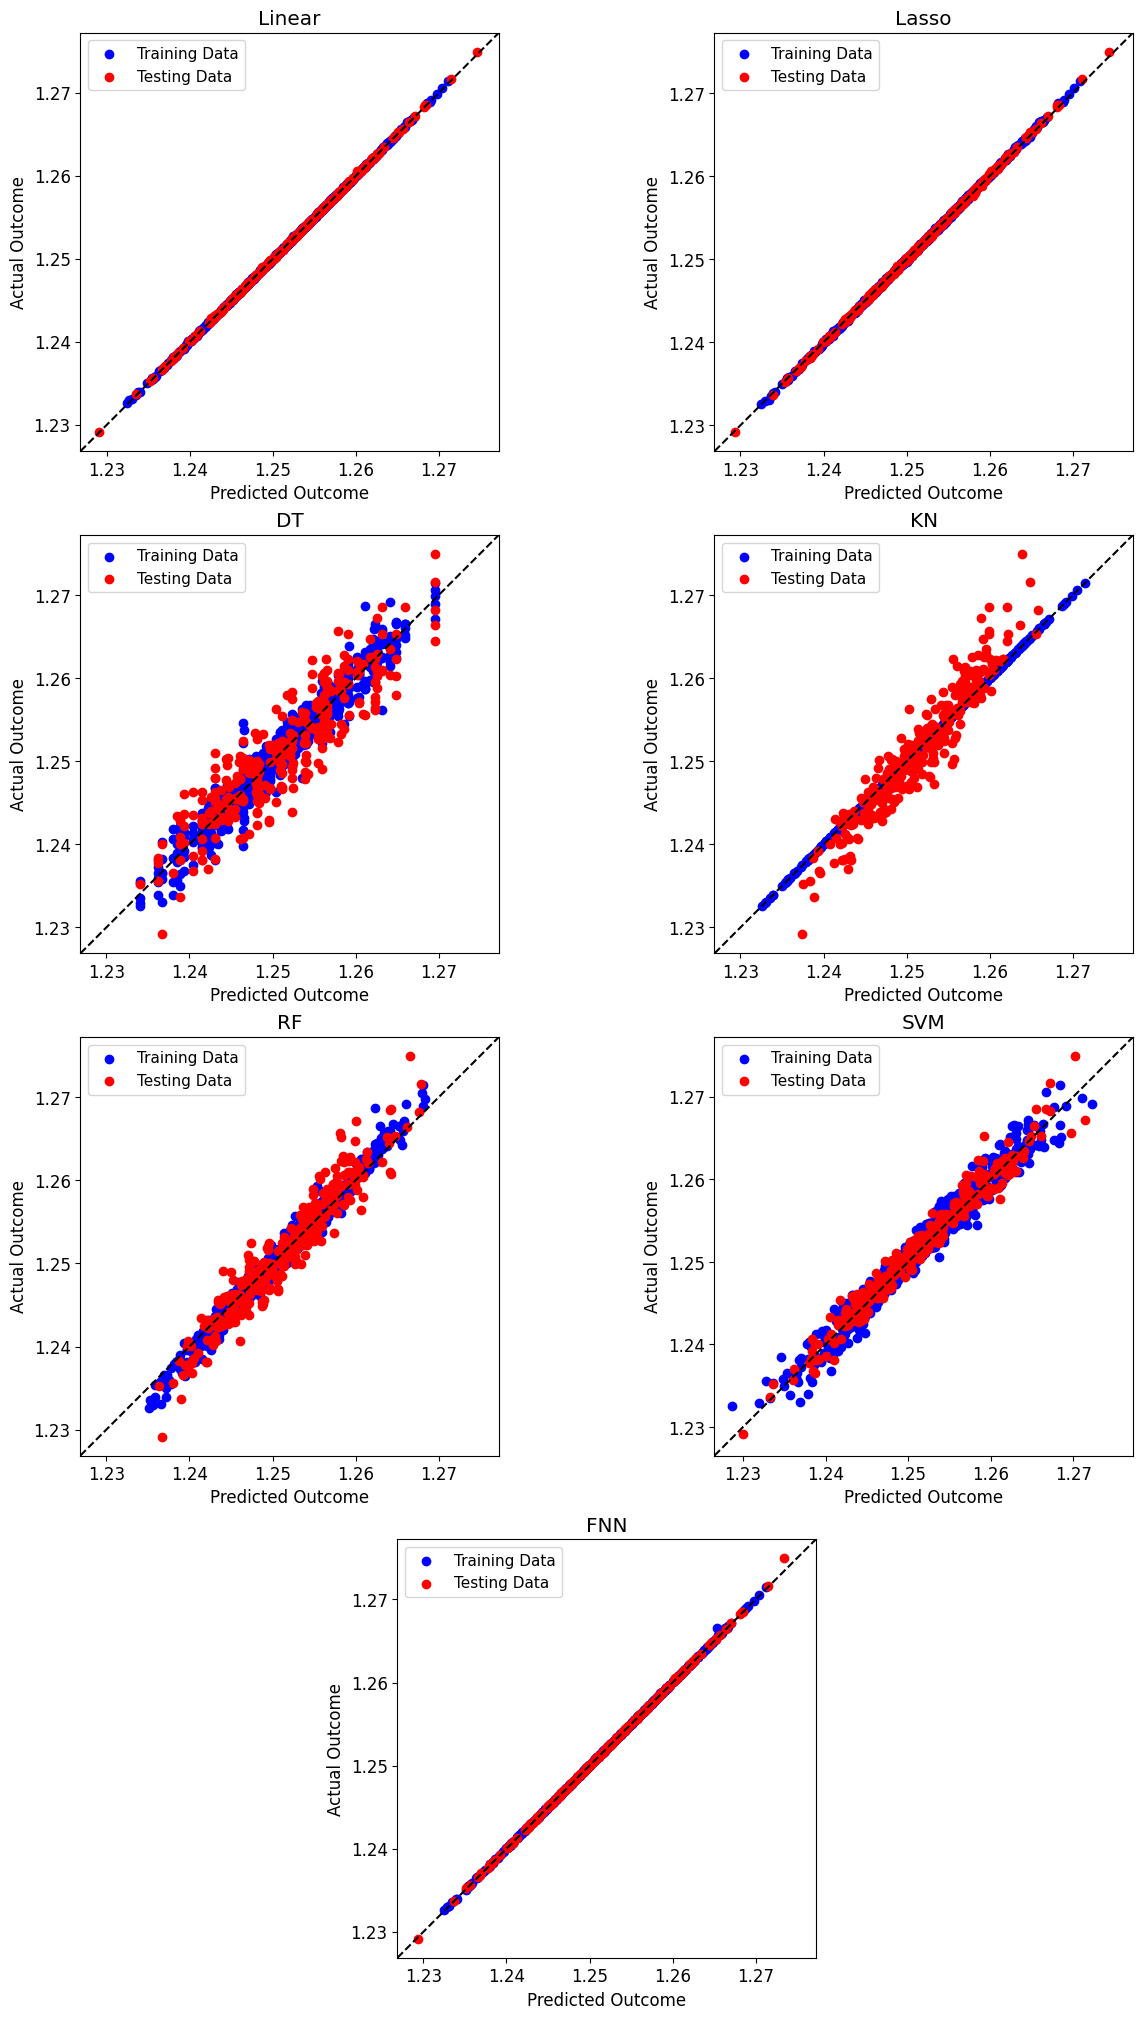

In [14]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "SVM"]])
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.diagonal_validation_plot(model_type="FNN")
ax.set_title("FNN")
plt.show()

Linear regression, lasso regression, and FNN are tightly spread near $y = x$. The overfit of k-nearest neighbors is apparent given the difference in the spread of training compared to testing data.

Validation plots tell us a similar story.

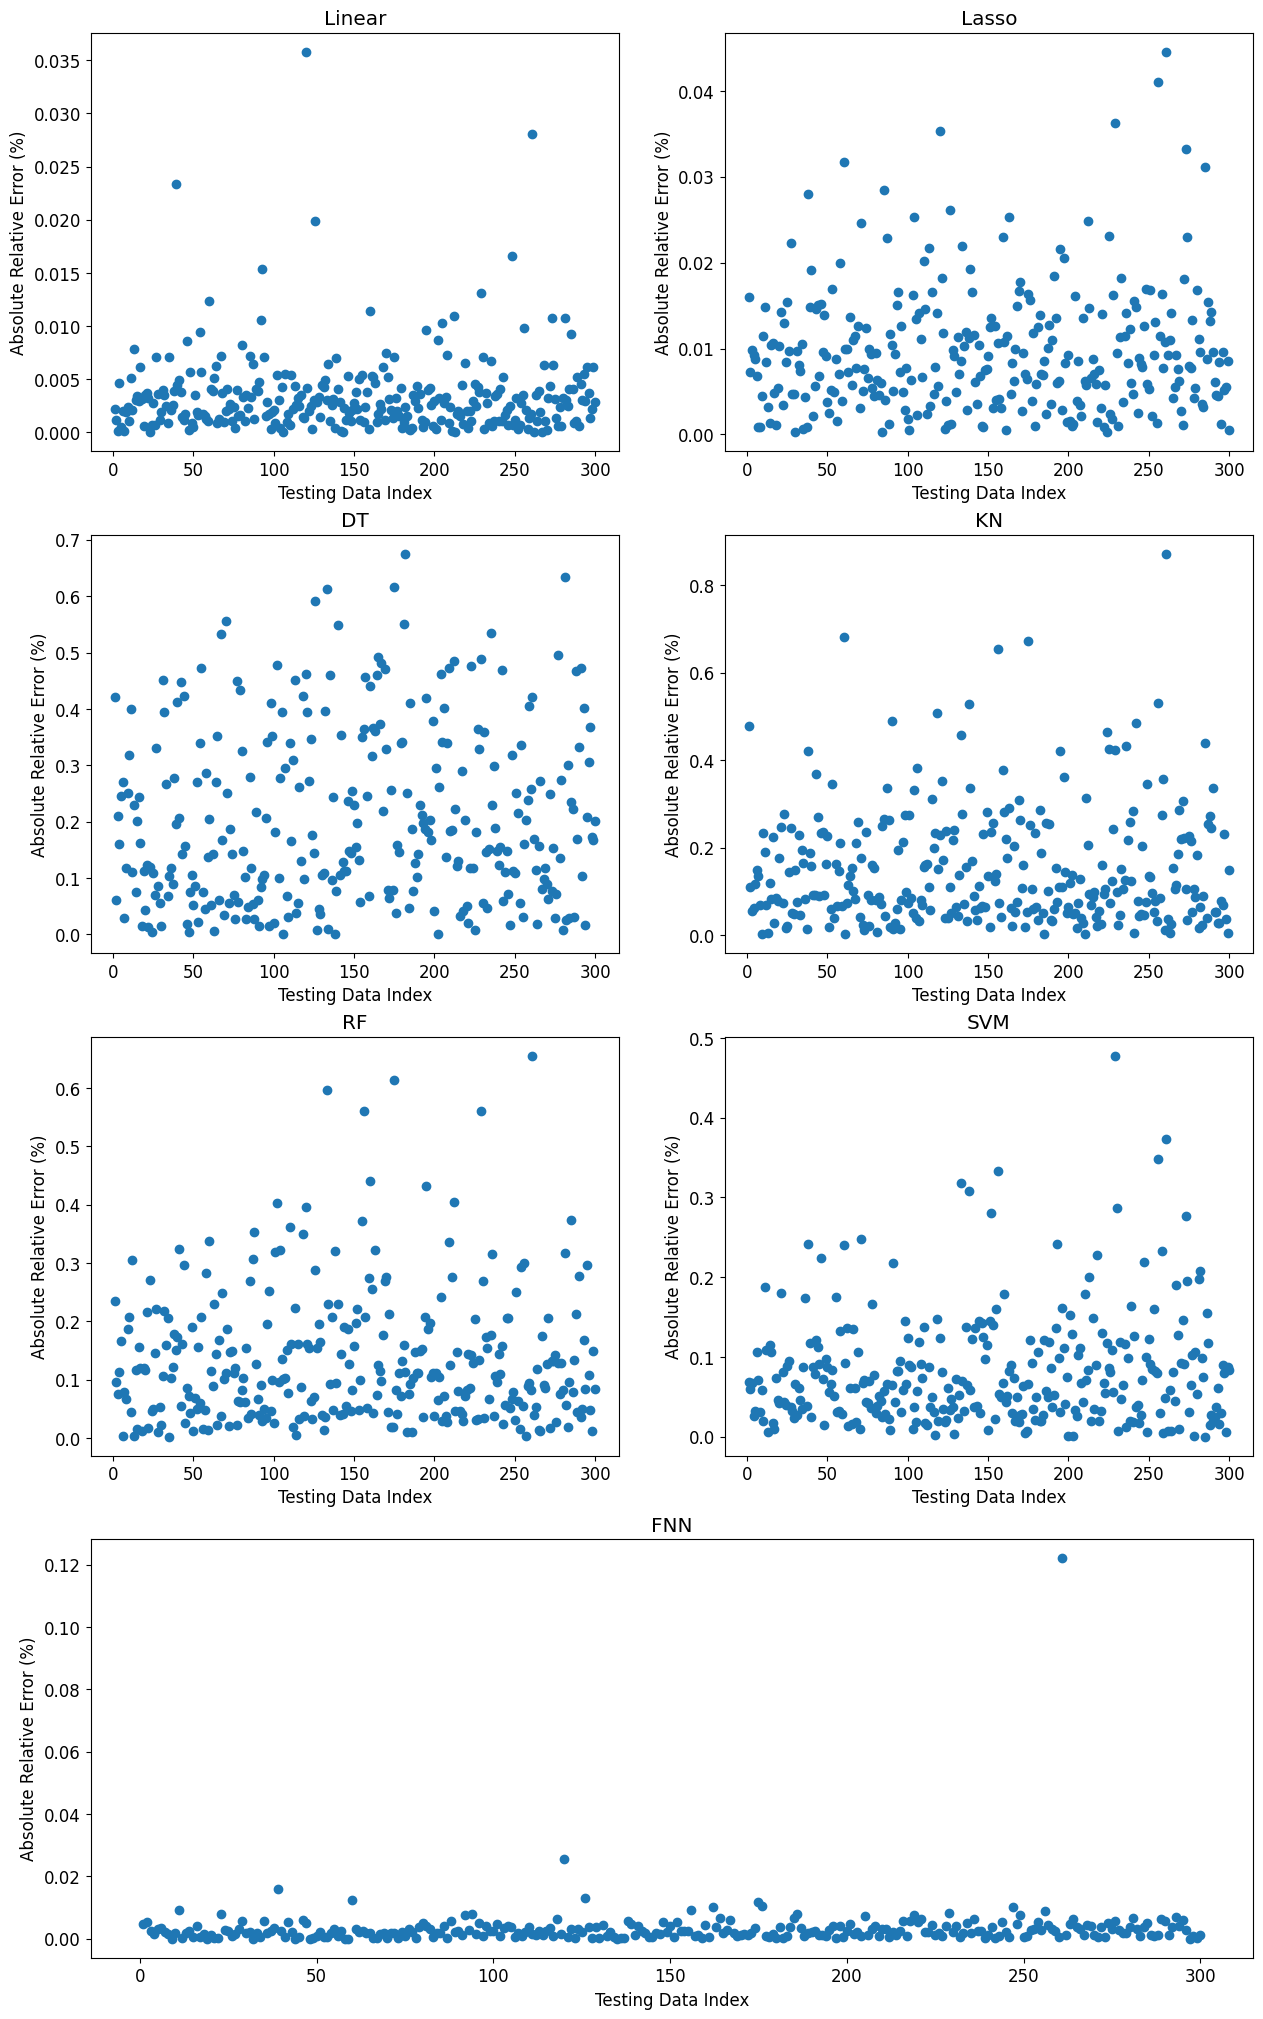

In [15]:
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.validation_plot(model_type="FNN")
ax.set_title("FNN")
plt.show()

Linear regression, lasso regression, and FNN all have testing relative errors of less than 0.15.

Finally, we can see if the FNN is overfit based on its learning curve.

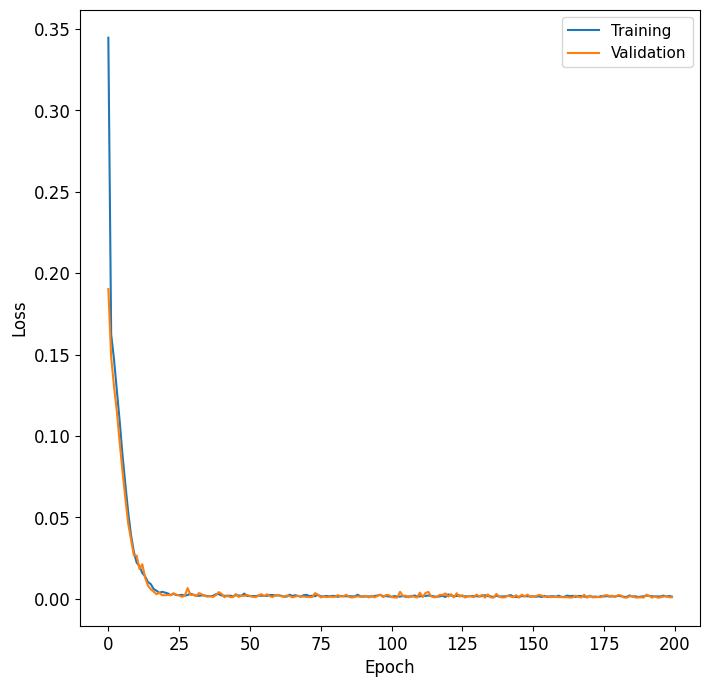

In [16]:
postprocessor.nn_learning_plot()
plt.show()

The validation curve is below the training curve; therefore, the best FNN based on test $R^2$ was not overfitting.

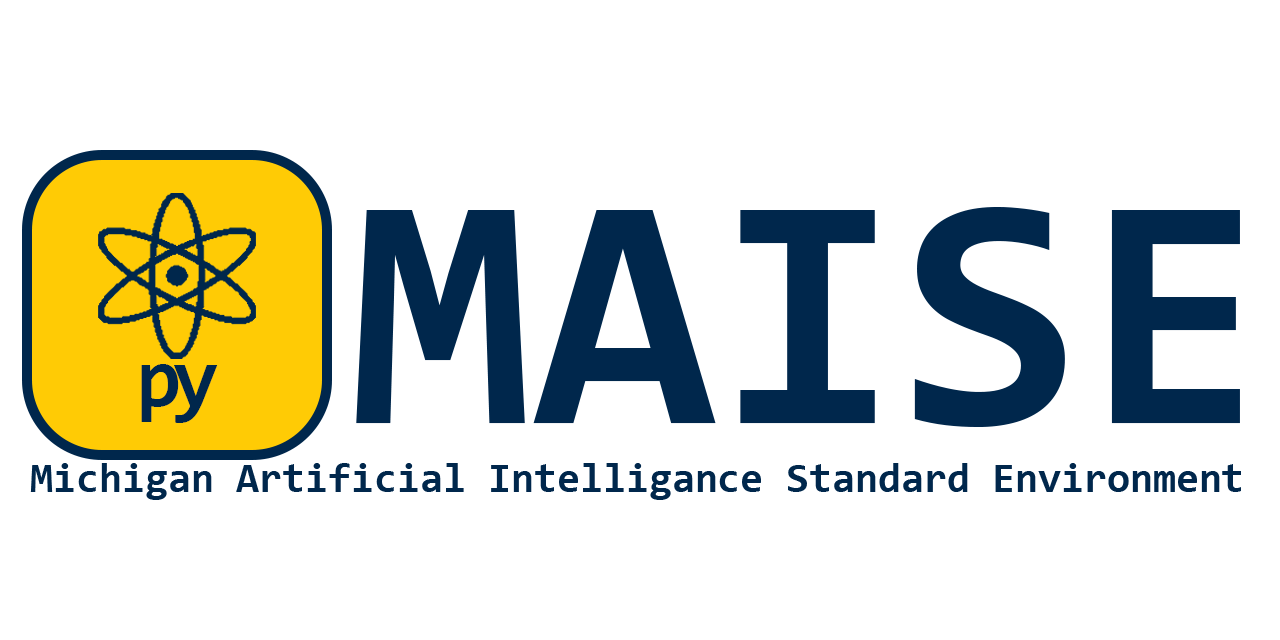